In [1]:
from datetime import datetime

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

globalMin = -20
globalMax = 20
globalDotCount = 20
globalBoxSize = 5
globalFigureSize = 14

In [2]:
# 生成随机点
def createUniformRandomDots(minVal, maxVal, count):
    dots = np.random.default_rng().uniform(minVal, maxVal, (count, 2))
    resdf = pd.DataFrame(dots, columns=["X", "Y"])
    plt.figure(figsize=(globalFigureSize, globalFigureSize))
    plt.xlim([globalMin - globalBoxSize, globalMax + globalBoxSize])
    plt.plot(resdf["X"], resdf["Y"], ".")
    plt.show()
    return resdf

In [16]:
# 设置每点所对应的方块
def setBox(row, xy, boxSize, result):
    if (
        xy[0] <= row["X"] < xy[0] + boxSize
        and xy[1] <= row["Y"] < xy[1] + boxSize
        and len(row["BoxLoc"]) == 0
    ):
        row["BoxLoc"].append(xy[0])
        row["BoxLoc"].append(xy[1])
        result.append((xy[0], xy[1]))


# 计算所需方块 - 全区域随机生成正方块
def calculateSurroundedBoxes(minVal, maxVal, dots, boxSize):
    dots["BoxLoc"] = dots.apply(lambda x: [], axis=1)
    result = []
    start = datetime.now()
    rowCount = len(dots)
    while True:
        xyArray = np.random.default_rng().uniform(minVal, maxVal, 2)
        dots.apply(lambda tmprow: setBox(tmprow, xyArray, boxSize, result), axis=1)
        if dots["BoxLoc"].map(lambda r: len(r)).sum() == rowCount * 2:
            break
    # print("running time :", datetime.now() - start)
    return result


# 计算所需方块 - 围绕着每一个点随机生成正方块
def calculateSurroundedBoxes2(minVal, maxVal, dots, boxSize):
    dots["BoxLoc"] = dots.apply(lambda x: [], axis=1)
    result = []
    start = datetime.now()
    rowCount = len(dots)
    while True:
        # 遍历出第一个未设定正方块的点
        tmpx = None
        tmpy = None
        for index, row in dots.iterrows():
            if len(row["BoxLoc"]) <= 0:
                tmpx = row["X"]
                tmpy = row["Y"]
                break
            pass

        shiftArray = np.random.default_rng().uniform(0, globalBoxSize, 2)
        tmpx = tmpx - shiftArray[0]
        tmpy = tmpy - shiftArray[1]

        for index, row in dots.iterrows():
            if (
                tmpx <= row["X"] < tmpx + globalBoxSize
                and tmpy <= row["Y"] < tmpy + globalBoxSize
                and len(row["BoxLoc"]) <= 0
            ):
                row["BoxLoc"].append(tmpx)
                row["BoxLoc"].append(tmpy)
                result.append((tmpx, tmpy))
            pass

        if dots["BoxLoc"].map(lambda r: len(r)).sum() == rowCount * 2:
            break
    # print("running time :", datetime.now() - start)
    return result


# 根据点在x轴和y轴的投影信息计算正方形
def calculateSurroundedBoxes3(dots):
    # 清空正方形
    dots["BoxLoc"] = dots.apply(lambda x: [], axis=1)
    dots["Siblings"] = dots.apply(lambda x: [], axis=1)
    dots["SibCount"] = 0

    # 计算每个点的相邻点
    for index, row in dots.iterrows():
        for tmpidx, tmprow in dots.iterrows():
            if (
                index != tmpidx
                and abs(row["X"] - tmprow["X"]) < globalBoxSize
                and abs(row["Y"] - tmprow["Y"]) < globalBoxSize
            ):
                row["Siblings"].append(tmpidx)
                pass
            elif index == tmpidx:
                row["Siblings"].append(tmpidx)
                pass
            pass
        dots.loc[index, "SibCount"] = len(row["Siblings"])
        pass
    dots["SibCount"] = dots.apply(lambda x: len(x["Siblings"]), axis=1)
    print(dots)

    # 将pandas按照Siblings数组的长度从大到小排序，每次选中第一个数组
    #  若选中的数组在属于结果list中任一元素的子集，则将此数组清空
    #  否则，挨个遍历此数组，移除属于结果list中任一元素的数
    resBoxList = []
    while True:
        if dots["SibCount"].sum() == 0:
            break
        sort = dots.sort_values("SibCount", ascending=False)
        tmpbox = sort.iloc[0, 3]
        # print("add from top", tmpbox)
        resBoxList.append(tmpbox.copy())
        for index, row in sort.iterrows():
            if len(row["Siblings"]) == 0:
                continue
            else:
                isSubset = False
                for tmpitem in resBoxList:
                    if set(row["Siblings"]).issubset(set(tmpitem)):
                        row["Siblings"].clear()
                        isSubset = True
                        break
                        pass
                    pass
                if isSubset:
                    continue
                else:
                    toremove = []
                    for tmpidx in row["Siblings"]:
                        for tmpitem in resBoxList:
                            if tmpidx in tmpitem:
                                toremove.append(tmpidx)
                            pass
                        pass
                    for tmprm in toremove:
                        row["Siblings"].remove(tmprm)
                    pass
                pass
            pass
        # end of for
        dots["SibCount"] = dots.apply(lambda x: len(x["Siblings"]), axis=1)
    # end of while
    results = []
    print("##resBoxList", resBoxList)
    for tmpcluster in resBoxList:
        tmpx = dots.loc[tmpcluster, "X"].sum() / len(tmpcluster)
        tmpy = dots.loc[tmpcluster, "Y"].sum() / len(tmpcluster)
        results.append((tmpx - globalBoxSize / 2, tmpy - globalBoxSize / 2))
        pass
    return results
    pass


def plotBox(samples, reslist):
    fig, ax = plt.subplots(1, figsize=(globalFigureSize, globalFigureSize))
    plt.xlim([globalMin - globalBoxSize, globalMax + globalBoxSize])
    plt.ylim([globalMin - globalBoxSize, globalMax + globalBoxSize])
    ax.plot(samples["X"], samples["Y"], ".")
    for index, row in samples.iterrows():
        ax.annotate(str(index), (row["X"], row["Y"]))
        pass
    for tmpbox in reslist:
        rect = patches.Rectangle(
            (tmpbox[0], tmpbox[1]),
            globalBoxSize,
            globalBoxSize,
            linewidth=1,
            edgecolor="r",
            facecolor="r",
            fill=False,
        )
        ax.add_patch(rect)
    plt.show()
    pass

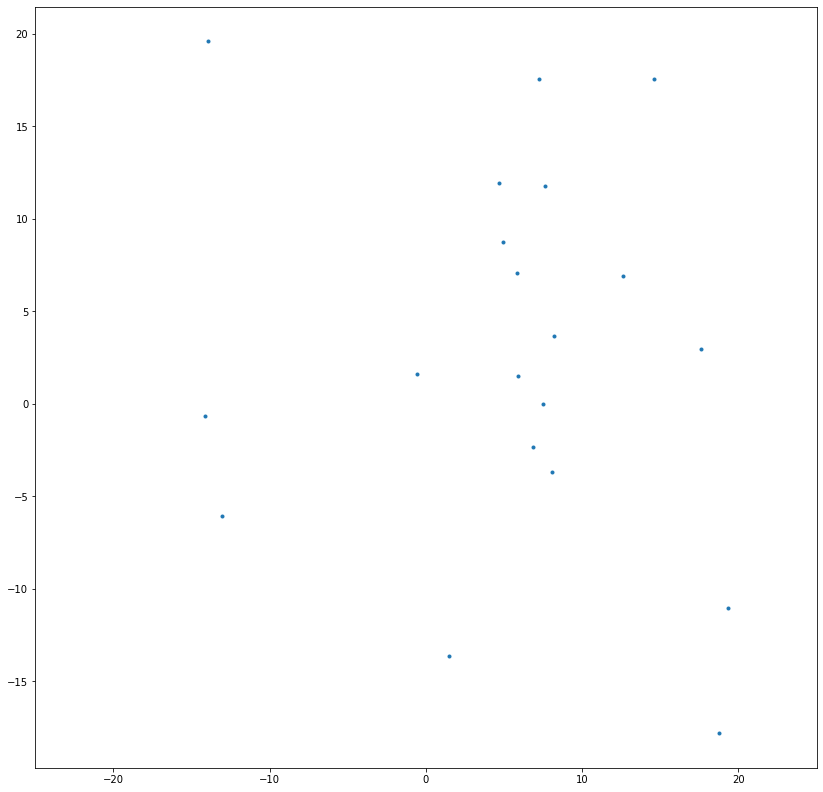

In [4]:
samples = createUniformRandomDots(globalMin, globalMax, globalDotCount)

In [17]:
reslist = calculateSurroundedBoxes3(samples)

            X          Y BoxLoc             Siblings  SibCount
0   14.598545  17.543219     []                  [0]         1
1    8.094377  -3.696924     []           [1, 2, 13]         3
2    6.885197  -2.326463     []       [1, 2, 13, 16]         4
3    5.815296   7.073731     []    [3, 5, 6, 10, 17]         5
4   19.303002 -11.028353     []                  [4]         1
5    4.655212  11.967767     []        [3, 5, 6, 10]         4
6    4.913763   8.776880     []        [3, 5, 6, 10]         4
7   18.738506 -17.815226     []                  [7]         1
8    1.490589 -13.653917     []                  [8]         1
9    7.231479  17.592922     []                  [9]         1
10   7.613674  11.767102     []    [3, 5, 6, 10, 12]         5
11 -13.035084  -6.081940     []                 [11]         1
12  12.604455   6.896842     []         [10, 12, 17]         3
13   7.518439  -0.031565     []   [1, 2, 13, 16, 17]         5
14  -0.598889   1.610118     []                 [14]   

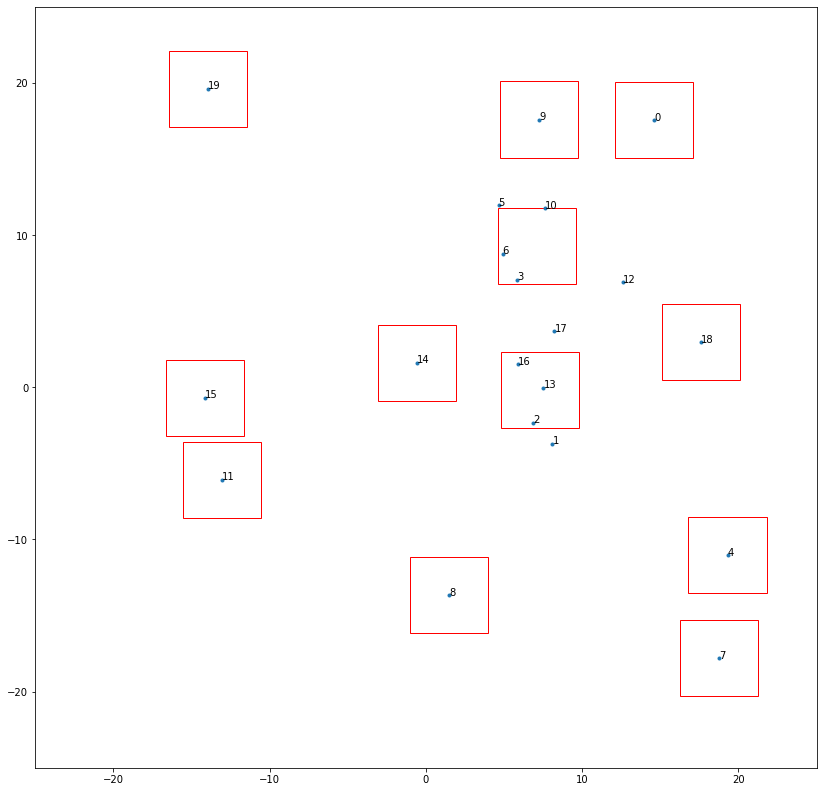

In [15]:
plotBox(samples, reslist)

In [7]:
allboxes = calculateSurroundedBoxes2(globalMin, globalMax, samples, globalBoxSize)
print(f"Count of All boxes is {len(allboxes)}")
for tmpi in range(100):
    tmpboxes = calculateSurroundedBoxes2(globalMin, globalMax, samples, globalBoxSize)
    if len(tmpboxes) < len(allboxes):
        print(f"{len(allboxes)} --> {len(tmpboxes)}")
        allboxes = tmpboxes
    else:
        # print(f"{set(tmpboxes) == set(allboxes)}")
        pass
    pass

Count of All boxes is 20


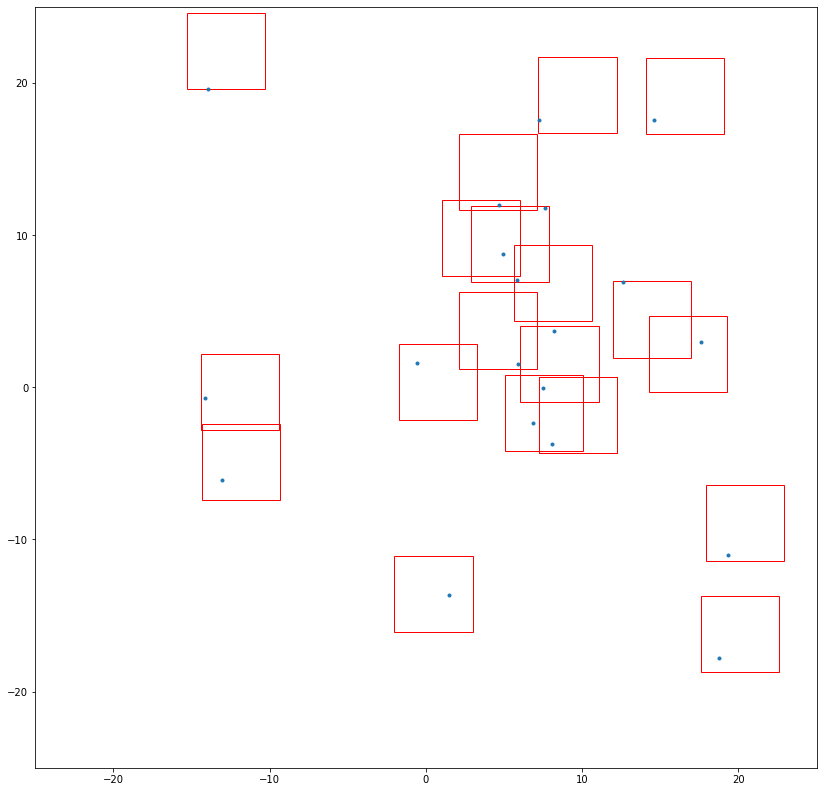

In [8]:
plotBox(samples, allboxes)